In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable

On this experiment i want to study the convergence of the graph model with adding an edge criterium
For this I will compare with a baseline model only taking into account the spectrum

In [44]:
np.random.seed(42)
datasets = f'../data/connectomes/'
connectomes = sorted(os.listdir(datasets)) 
print(connectomes)

# Create the necessary directories
os.makedirs('../images/imgs_edge_criterium_study/', exist_ok=True)
os.makedirs('./runs/edge_criterium_study/', exist_ok=True)

['c.elegans.herm_pharynx_1.graphml', 'c.elegans_neural.male_1.graphml', 'drosophila_medulla_1.graphml', 'kasthuri_graph_v4.graphml', 'mixed.species_brain_1.graphml', 'mouse_brain_1.graphml', 'mouse_retina_1.graphml', 'mouse_visual.cortex_1.graphml', 'mouse_visual.cortex_2.graphml', 'p.pacificus_neural.synaptic_1.graphml', 'p.pacificus_neural.synaptic_2.graphml', 'rattus.norvegicus_brain_1.graphml', 'rattus.norvegicus_brain_2.graphml', 'rattus.norvegicus_brain_3.graphml', 'rhesus_brain_1.graphml', 'rhesus_brain_2.graphml', 'rhesus_cerebral.cortex_1.graphml', 'rhesus_interareal.cortical.network_2.graphml']


# simulation

In [60]:
def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL', edge_delta=None, min_gic_threshold=None, verbose=True):
   """
   Estimates parameters, generates a graph using the Logit Graph model,
   and calculates GIC, allowing for different convergence criteria.

   Args:
       real_graph (nx.Graph or np.ndarray): The target graph.
       d (int): Parameter for the Logit model (number of neighbors).
       n_iteration (int): Maximum number of iterations for graph generation.
       warm_up (int): Number of initial iterations to discard.
       patience (int): Number of iterations to wait for improvement before stopping.
       dist_type (str): Distance type for GIC ('KL', 'L1', 'L2').
       convergence_criteria (str): Criterion for stopping ('spectrum' or 'spectrum_and_edges').

   Returns:
       tuple: Contains the best generated graph, sigma, GIC values,
              spectrum differences, edge differences, best iteration index, and all graphs.
   """
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)

   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   # Using default L1 regularization as before, adjust if needed
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up,
      "patience": patience,
      "edge_delta": edge_delta,
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)

   print(f"Running generation with convergence criterion: {edge_delta}")
   
   graphs, spec, spectrum_diffs, best_iteration, best_graph_arr = graph_model.populate_edges_spectrum_min_gic(
        max_iterations=n_iteration,
        # warm_up=warm_up,
        patience=patience,
        real_graph=real_graph,
        edge_delta=edge_delta,
        min_gic_threshold=min_gic_threshold,
        gic_dist_type=dist_type,
        verbose=verbose,
    )


   print(f"Finish generation with convergence criterion: {edge_delta}")
   # Calculate edge differences
   real_edges = np.sum(real_graph) / 2
   edge_diffs = [abs(np.sum(g) / 2 - real_edges) for g in graphs]

   # Use the best graph found based on the selected criteria/iteration
   # best_graph = graphs[best_iteration]

   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph_arr)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type
   ).calculate_gic()

   return best_graph_arr, sigma, [gic_value], spectrum_diffs, edge_diffs, best_iteration, graphs


In [61]:
# Good connectomes Previously fitted and had nice results
good_connectomes = [
    'c.elegans_neural.male_1.graphml',
    'mouse_brain_1.graphml',
    'mouse_visual.cortex_2.graphml',
    'p.pacificus_neural.synaptic_2.graphml',
    'rhesus_brain_2.graphml'
]

connectome_file = 'rhesus_brain_2.graphml'
# connectome_file = 'p.pacificus_neural.synaptic_2.graphml'
# connectome_file = 'mouse_visual.cortex_2.graphml'
# connectome_file = 'mouse_brain_1.graphml'
# connectome_file = 'c.elegans_neural.male_1.graphml'

# Select a graph from the dataset
connectome_name = connectome_file  # Use the selected connectome file
print(f"Using connectome: {connectome_name}")
real_graph_path = datasets + connectome_name

# Read the GraphML file
real_graph_nx = nx.read_graphml(real_graph_path)
adj_matrix = nx.to_numpy_array(real_graph_nx)
n_nodes = real_graph_nx.number_of_nodes()
print(f"Number of nodes: {n_nodes}")

edge_delta = len(real_graph_nx.edges()) * 0.05  # Calculate 5% of total edges


Using connectome: rhesus_brain_2.graphml
Number of nodes: 91


In [62]:
sim_params = {
    "d": 0, # Logit model parameter (adjust if needed)
    "n_iteration": 5000, # Max iterations
    "warm_up": 500,      # Burn-in period
    "patience": 500,     # Patience for early stopping
    "dist_type": 'KL'    # GIC distance type
}

edge_delta = int(len(real_graph_nx.edges()) * 0.05)  # Calculate 5% of total edges
print(f"Edge delta: {edge_delta}")
results = {}

Edge delta: 31


In [63]:
# --- Run Baseline (Spectrum Convergence) ---
print("-" * 20)
print("Running Baseline Model (Spectrum Convergence)")
print("-" * 20)
baseline_results = get_logit_graph(
    real_graph=adj_matrix.copy(), # Pass a copy
    d=sim_params["d"],
    n_iteration=sim_params["n_iteration"],
    warm_up=sim_params["warm_up"],
    patience=sim_params["patience"],
    dist_type=sim_params["dist_type"],
    edge_delta=None,
    min_gic_threshold=10,
)

results['Baseline_Spectrum'] = {
    "graph": baseline_results[0],
    "sigma": baseline_results[1],
    "GIC": baseline_results[2][0],
    "spectrum_diffs": baseline_results[3],
    "edge_diffs": baseline_results[4],
    "best_iteration": baseline_results[5],
    "all_graphs": baseline_results[6] # Optional: store if memory allows
}
print(f"Baseline Best Iteration: {results['Baseline_Spectrum']['best_iteration']}")
print(f"Baseline Final GIC: {results['Baseline_Spectrum']['GIC']:.4f}")
gc.collect() # Clean up memory



--------------------
Running Baseline Model (Spectrum Convergence)
--------------------
Running generation with convergence criterion: None
iteration: 0
	 Current GIC (KL): inf (Threshold: 10)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 243.0)
iteration: 1000
	 Current GIC (KL): 13.9394 (Threshold: 10)
	 Best Spectrum Diff: 209.0876
	 Patience: 0/500
	 Current edges: 4.0 (Real edges: 243.0)
iteration: 2000
	 Current GIC (KL): 23.3299 (Threshold: 10)
	 Best Spectrum Diff: 207.1794
	 Patience: 0/500
	 Current edges: 6.0 (Real edges: 243.0)

*** GIC threshold 10 reached at iteration 2621 (GIC: 4.6587) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***

iteration: 3000
	 Best Spectrum Diff: 201.7293
	 Patience: 45/500
	 Current edges: 17.0 (Real edges: 243.0)
iteration: 4000
	 Best Spectrum Diff: 149.8411
	 Patience: 0/500
	 Current edges: 192.0 (Real edges: 243.0)

--- Stopping Condition Met ---
- Reason: No improvement in

10765

In [64]:
# --- Run Edge Criterion Model (Spectrum + Edges Convergence) ---
print("-" * 20)
print("Running Enhanced Model (Spectrum + Edge Convergence)")
print("-" * 20)
edge_crit_results = get_logit_graph(
    real_graph=adj_matrix.copy(), # Pass a copy
    d=sim_params["d"],
    n_iteration=sim_params["n_iteration"],
    warm_up=sim_params["warm_up"],
    patience=sim_params["patience"],
    dist_type=sim_params["dist_type"],
    edge_delta=edge_delta,
    min_gic_threshold=10,
)

results['Enhanced_Edges'] = {
    "graph": edge_crit_results[0],
    "sigma": edge_crit_results[1],
    "GIC": edge_crit_results[2][0],
    "spectrum_diffs": edge_crit_results[3],
    "edge_diffs": edge_crit_results[4],
    "best_iteration": edge_crit_results[5],
    "all_graphs": edge_crit_results[6] # Optional: store if memory allows
}
print(f"Enhanced Best Iteration: {results['Enhanced_Edges']['best_iteration']}")
print(f"Enhanced Final GIC: {results['Enhanced_Edges']['GIC']:.4f}")
gc.collect() # Clean up memory



--------------------
Running Enhanced Model (Spectrum + Edge Convergence)
--------------------
Running generation with convergence criterion: 31
iteration: 0
	 Current GIC (KL): inf (Threshold: 10)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 243.0)
iteration: 1000
	 Current GIC (KL): 23.3250 (Threshold: 10)
	 Best Spectrum Diff: 207.3132
	 Patience: 0/500
	 Current edges: 7.0 (Real edges: 243.0)

*** GIC threshold 10 reached at iteration 1261 (GIC: 4.9836) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***

iteration: 2000
	 Best Spectrum Diff: 200.5334
	 Patience: 13/500
	 Current edges: 21.0 (Real edges: 243.0)
Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (31).

--- Results ---
- Best iteration found: 2975
- Best spectrum difference: 139.7207
- Edges in best graph: 275.0 (Real graph edges: 243.0)
Finish generation with convergence criterion: 31
Enha

4908

# Full connectomes

In [95]:
good_connectomes = [
    'c.elegans_neural.male_1.graphml',
    'mouse_brain_1.graphml',
    'mouse_visual.cortex_2.graphml',
    'p.pacificus_neural.synaptic_2.graphml',
    'rhesus_brain_2.graphml'
]

sim_params = {
    "d": 0,                 # Logit model parameter (adjust if needed)
    "n_iteration": 30_000,  # Max iterations
    "warm_up": 500,         # Burn-in period DEPRECATED
    "patience": 5000,       # Patience for early stopping
    "dist_type": 'KL',      # GIC distance type
    "min_gic_threshold": 5, #
    "verbose": True,        #
}

In [ ]:
# --- Main Simulation Loop ---
all_results = {} # Store results for all connectomes (optional, mainly for plotting later)

for connectome_file in good_connectomes:
    print(f"\n{'='*20} Processing: {connectome_file} {'='*20}")

    # --- Load Data ---
    connectome_name = connectome_file
    print(f"Using connectome: {connectome_name}")
    real_graph_path = datasets + connectome_name
    try:
        real_graph_nx = nx.read_graphml(real_graph_path)
        # Ensure graph is undirected and has no self-loops for consistency
        real_graph_nx = nx.Graph(real_graph_nx)
        real_graph_nx.remove_edges_from(nx.selfloop_edges(real_graph_nx))
    except Exception as e:
        print(f"Error reading graph {connectome_name}: {e}")
        continue # Skip to the next connectome if loading fails

    adj_matrix = nx.to_numpy_array(real_graph_nx)
    n_nodes = real_graph_nx.number_of_nodes()
    n_edges_real = real_graph_nx.number_of_edges()
    print(f"Number of nodes: {n_nodes}, Number of edges: {n_edges_real}")

    # Calculate edge delta for this specific graph
    edge_delta = int(n_edges_real * 0.05)
    print(f"Edge delta (5% of edges): {edge_delta}")

    # Initialize results for the current connectome
    results = {}

    # --- Run Baseline (Spectrum Convergence) ---
    print("-" * 20)
    print("Running Baseline Model (Spectrum Convergence)")
    print("-" * 20)
    try:
        baseline_results = get_logit_graph(
            real_graph=adj_matrix.copy(), # Pass a copy
            d=sim_params["d"],
            n_iteration=sim_params["n_iteration"],
            warm_up=sim_params["warm_up"],
            patience=sim_params["patience"],
            dist_type=sim_params["dist_type"],
            edge_delta=None, # Explicitly None for baseline
            min_gic_threshold=sim_params["min_gic_threshold"],
            verbose=sim_params["verbose"],
        )

        results['Baseline_Spectrum'] = {
            "graph": nx.from_numpy_array(baseline_results[0]), # Store as nx.Graph
            "sigma": baseline_results[1],
            "GIC": baseline_results[2][0],
            "spectrum_diffs": baseline_results[3],
            "edge_diffs": baseline_results[4],
            "best_iteration": baseline_results[5],
            # "all_graphs": baseline_results[6] # Consider removing if memory is an issue
        }
        print(f"Baseline Best Iteration: {results['Baseline_Spectrum']['best_iteration']}")
        print(f"Baseline Final GIC: {results['Baseline_Spectrum']['GIC']:.4f}")
        print(f"Baseline Final Edges: {results['Baseline_Spectrum']['graph'].number_of_edges()}")

    except Exception as e:
        print(f"Error during Baseline run for {connectome_name}: {e}")
        results['Baseline_Spectrum'] = None # Indicate failure

    gc.collect() # Clean up memory

    # --- Run Edge Criterion Model (Spectrum + Edges Convergence) ---
    print("-" * 20)
    print("Running Enhanced Model (Spectrum + Edge Convergence)")
    print("-" * 20)
    try:
        edge_crit_results = get_logit_graph(
            real_graph=adj_matrix.copy(), # Pass a copy
            d=sim_params["d"],
            n_iteration=sim_params["n_iteration"],
            warm_up=sim_params["warm_up"],
            patience=sim_params["patience"],
            dist_type=sim_params["dist_type"],
            edge_delta=edge_delta, # Use calculated edge_delta
            min_gic_threshold=sim_params["min_gic_threshold"],
            verbose=sim_params["verbose"],
        )

        results['Enhanced_Edges'] = {
            "graph": nx.from_numpy_array(edge_crit_results[0]), # Store as nx.Graph
            "sigma": edge_crit_results[1],
            "GIC": edge_crit_results[2][0],
            "spectrum_diffs": edge_crit_results[3],
            "edge_diffs": edge_crit_results[4],
            "best_iteration": edge_crit_results[5],
            # "all_graphs": edge_crit_results[6] # Consider removing if memory is an issue
        }
        print(f"Enhanced Best Iteration: {results['Enhanced_Edges']['best_iteration']}")
        print(f"Enhanced Final GIC: {results['Enhanced_Edges']['GIC']:.4f}")
        print(f"Enhanced Final Edges: {results['Enhanced_Edges']['graph'].number_of_edges()}")

    except Exception as e:
        print(f"Error during Enhanced run for {connectome_name}: {e}")
        results['Enhanced_Edges'] = None # Indicate failure

    gc.collect() # Clean up memory

    # --- Store results ---
    # Add real graph info for comparison
    results['Real'] = {
        "graph": real_graph_nx,
        "n_edges": n_edges_real
    }
    all_results[connectome_name] = results # Store in memory (optional)

    # Save results to file
    save_filename = f"./runs/edge_criterium_study/{connectome_name.replace('.graphml', '')}_results.pkl"
    try:
        with open(save_filename, 'wb') as f:
            pickle.dump(results, f)
        print(f"Results saved to {save_filename}")
    except Exception as e:
        print(f"Error saving results for {connectome_name}: {e}")

    print(f"Finished processing: {connectome_name}")

print("\nAll connectomes processed.")


==================== Processing: c.elegans_neural.male_1.graphml ====================
Using connectome: c.elegans_neural.male_1.graphml
Number of nodes: 272, Number of edges: 2902
Edge delta (5% of edges): 145
--------------------
Running Baseline Model (Spectrum Convergence)
--------------------
Running generation with convergence criterion: None
iteration: 0
	 Current GIC (KL): inf (Threshold: 5)
	 Best Spectrum Diff: inf
	 Patience: 0/5000
	 Current edges: 0.0 (Real edges: 2902.0)
iteration: 1000
	 Current GIC (KL): 23.0241 (Threshold: 5)
	 Best Spectrum Diff: 445.8287
	 Patience: 0/5000
	 Current edges: 2.0 (Real edges: 2902.0)
iteration: 2000
	 Current GIC (KL): 10.1039 (Threshold: 5)
	 Best Spectrum Diff: 442.9554
	 Patience: 0/5000
	 Current edges: 12.0 (Real edges: 2902.0)
iteration: 3000
	 Current GIC (KL): 9.1755 (Threshold: 5)
	 Best Spectrum Diff: 438.9387
	 Patience: 0/5000
	 Current edges: 29.0 (Real edges: 2902.0)
iteration: 4000
	 Current GIC (KL): 7.1383 (Threshold: 5

# Plotting


Generating combined plot for: p.pacificus_neural.synaptic_2.graphml
Combined plot saved to ../images/imgs_edge_criterium_study/p.pacificus_neural.synaptic_2_combined_comparison.png


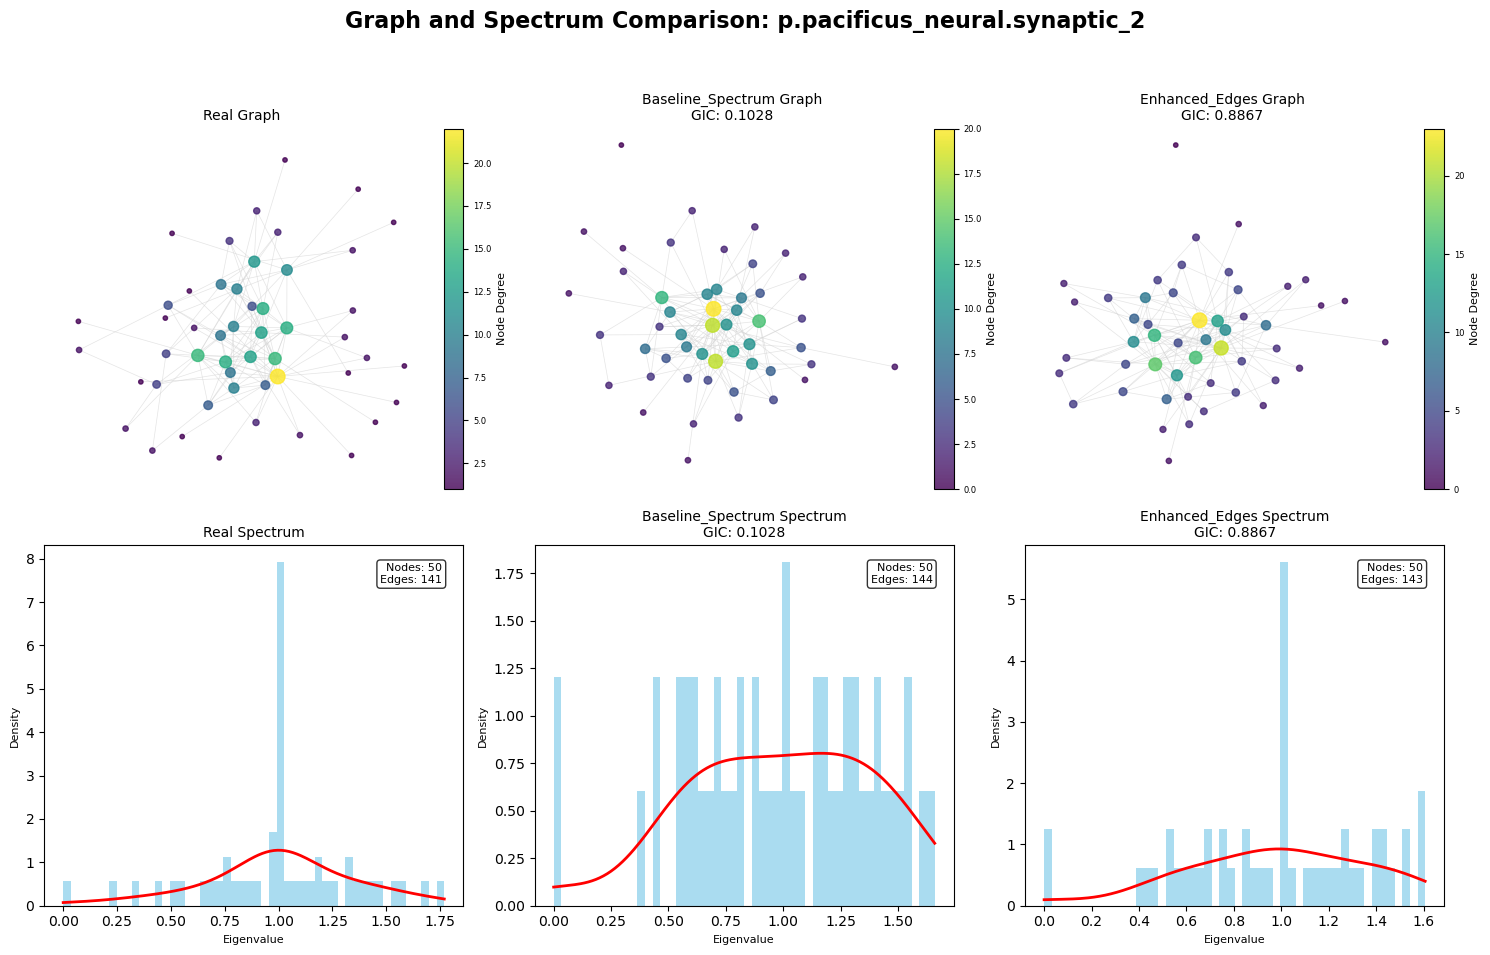


Generating combined plot for: rhesus_brain_2.graphml
Combined plot saved to ../images/imgs_edge_criterium_study/rhesus_brain_2_combined_comparison.png


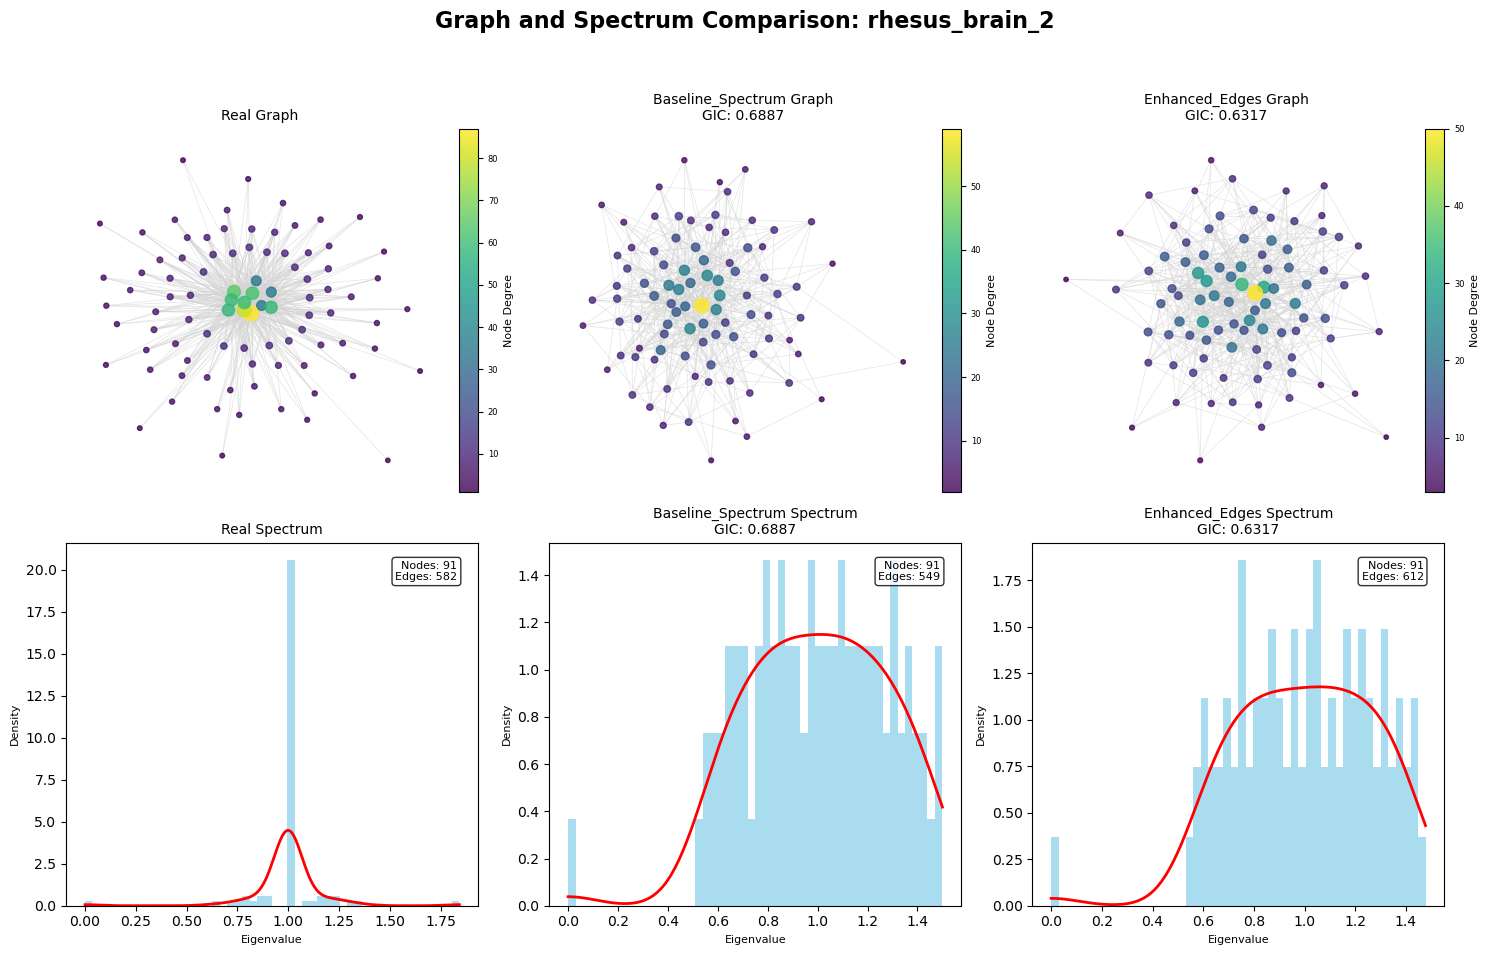


Finished generating individual connectome plots.


In [ ]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import gc
import os

# --- Helper functions extracted and adapted from provided plot functions ---

def plot_single_graph(ax, G, name, result_dict):
    """Plots a single graph on a given Axes object."""
    # Use force-directed layout for better distribution of nodes
    pos = nx.spring_layout(G, k=0.5, iterations=50) # Consider adjusting k and iterations

    # Normalize node sizes and reduce
    degrees = dict(G.degree())
    if not degrees: # Handle empty graph case
        nx.draw_networkx_nodes(G, pos, node_size=10, ax=ax)
        ax.set_title(f'{name} Graph (Empty)', fontsize=10)
        ax.axis('off')
        return

    max_degree = max(degrees.values()) if degrees else 1
    min_degree = min(degrees.values()) if degrees else 0
    # Avoid division by zero if all degrees are the same
    degree_range = max_degree - min_degree
    if degree_range == 0:
        node_sizes = [20 for node in G.nodes()] # Assign a default size
    else:
        node_sizes = [((degrees[node] - min_degree) / degree_range) * 100 + 10 for node in G.nodes()]


    # Normalize node colors
    node_color = list(degrees.values())

    # Draw edges first
    edge_color = 'lightgray'
    alpha = 0.6 # Reduced alpha for potentially dense plots
    width = 0.5 # Reduced width
    # Simplified edge drawing for performance, consider sampling if needed
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=alpha, width=width, ax=ax)

    # Draw nodes on top of edges
    scatter = nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes,
                                     cmap=plt.cm.viridis, ax=ax, alpha=0.8)

    # Set plot details
    title = f'{name} Graph'
    if name != 'Real' and name in result_dict and 'GIC' in result_dict[name] and not np.isnan(result_dict[name]['GIC']):
        title += f'\nGIC: {result_dict[name]["GIC"]:.4f}'
    ax.set_title(title, fontsize=10)
    ax.axis('off')

    # Add a colorbar to show degree scale only if nodes were drawn
    if G.number_of_nodes() > 0 and node_color:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        try:
            cbar = plt.colorbar(scatter, cax=cax)
            cbar.set_label('Node Degree', fontsize=8)
            cbar.ax.tick_params(labelsize=6)
        except Exception as e:
            print(f"Warning: Could not create colorbar for {name}: {e}") # Handle potential errors with colorbar


def plot_single_spectrum(ax, G, name, result_dict, bins):
    """Plots the spectrum of a single graph on a given Axes object."""
    if G.number_of_nodes() == 0:
        ax.set_title(f'{name} Spectrum (Empty Graph)', fontsize=10)
        ax.set_xlabel('Eigenvalue', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=10)
        return

    # Calculate the spectrum (eigenvalues) of the graph
    try:
        laplacian = nx.normalized_laplacian_matrix(G)
        eigenvalues = np.linalg.eigvals(laplacian.toarray())
        eigenvalues = np.real(eigenvalues)  # Take only the real part
    except Exception as e:
        print(f"Error calculating spectrum for {name}: {e}")
        ax.set_title(f'{name} Spectrum (Error)', fontsize=10)
        return


    # Plot histogram of eigenvalues
    ax.hist(eigenvalues, bins=bins, density=True, alpha=0.7, color='skyblue')

    # Calculate and plot KDE if possible
    if len(eigenvalues) > 1: # KDE requires more than one point
        try:
            kde = stats.gaussian_kde(eigenvalues)
            x_range = np.linspace(min(eigenvalues), max(eigenvalues), 200)
            ax.plot(x_range, kde(x_range), 'r-', lw=2)
        except Exception as e:
            print(f"Warning: Could not plot KDE for {name}: {e}") # KDE might fail for certain distributions

    # Set plot details
    title = f'{name} Spectrum'
    if name != 'Real' and name in result_dict and 'GIC' in result_dict[name] and not np.isnan(result_dict[name]['GIC']):
         title += f'\nGIC: {result_dict[name]["GIC"]:.4f}'
    ax.set_title(title, fontsize=10) # Reduced fontsize
    ax.set_xlabel('Eigenvalue', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Add text with graph properties
    props = f"Nodes: {G.number_of_nodes()}\nEdges: {G.number_of_edges()}"
    ax.text(0.95, 0.95, props, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


# --- Plotting Comparisons for Each Connectome ---

plot_save_dir = '../images/imgs_edge_criterium_study/'
os.makedirs(plot_save_dir, exist_ok=True)

for connectome_name, results in all_results.items():
    print(f"\nGenerating combined plot for: {connectome_name}")
    base_name = connectome_name.replace('.graphml', '')

    # Prepare data for plotting functions
    sim_graphs_dict = {}
    result_dict_for_plot = {} # Renamed to avoid conflict with loop variable 'results'

    # Add Real Graph
    if 'Real' in results and results['Real'] is not None:
         sim_graphs_dict['Real'] = results['Real']['graph']
         # No GIC for real graph, add dummy entry if needed by plot function structure
         result_dict_for_plot['Real'] = {'GIC': np.nan} # Or handle in plot function

    # Add Baseline Graph
    if 'Baseline_Spectrum' in results and results['Baseline_Spectrum'] is not None:
        sim_graphs_dict['Baseline_Spectrum'] = results['Baseline_Spectrum']['graph']
        result_dict_for_plot['Baseline_Spectrum'] = {'GIC': results['Baseline_Spectrum']['GIC']}
    else:
        print(f"Skipping Baseline plots for {connectome_name} due to missing results.")


    # Add Enhanced Graph
    if 'Enhanced_Edges' in results and results['Enhanced_Edges'] is not None:
        sim_graphs_dict['Enhanced_Edges'] = results['Enhanced_Edges']['graph']
        result_dict_for_plot['Enhanced_Edges'] = {'GIC': results['Enhanced_Edges']['GIC']}
    else:
         print(f"Skipping Enhanced plots for {connectome_name} due to missing results.")

    # Check if we have enough graphs to plot
    num_graphs = len(sim_graphs_dict)
    if num_graphs < 1: # Need at least one graph to plot
        print(f"Skipping plots for {connectome_name} due to insufficient successful runs.")
        continue

    # --- Generate Combined Plot (Graph Visualizations + Spectra) ---
    try:
        fig, axes = plt.subplots(2, num_graphs, figsize=(num_graphs * 5, 10)) # 2 rows, num_graphs columns
        # Ensure axes is always 2D, even if num_graphs is 1
        if num_graphs == 1:
            axes = axes.reshape(2, 1)

        plot_items = list(sim_graphs_dict.items()) # Ensure consistent order

        for i in range(num_graphs):
            name, G = plot_items[i]
            ax_graph = axes[0, i]
            ax_spec = axes[1, i]

            # Plot Graph Visualization
            plot_single_graph(ax_graph, G, name, result_dict_for_plot)

            # Plot Spectrum
            plot_single_spectrum(ax_spec, G, name, result_dict_for_plot, bins=50) # Adjust bins as needed

        # Set overall title and adjust layout
        fig.suptitle(f'Graph and Spectrum Comparison: {base_name}', fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to prevent title overlap

        # Save the combined figure
        combined_save_path = os.path.join(plot_save_dir, f'{base_name}_combined_comparison.png')
        fig.savefig(combined_save_path, bbox_inches='tight', dpi=300)
        print(f"Combined plot saved to {combined_save_path}")

        plt.show() # Show plot in notebook
        plt.close(fig) # Close the figure to free memory

    except Exception as e:
        print(f"Error generating combined plot for {connectome_name}: {e}")
        # Attempt to close the figure even if an error occurred during plotting/saving
        try:
            plt.close(fig)
        except NameError: # Figure might not have been created
            pass
        except Exception as close_e: # Catch potential errors during close
             print(f"Error closing figure: {close_e}")


    gc.collect() # Clean memory after plotting each connectome

print("\nFinished generating individual connectome plots.")


Overall edge comparison plot saved to ../images/imgs_edge_criterium_study/overall_edge_comparison.png


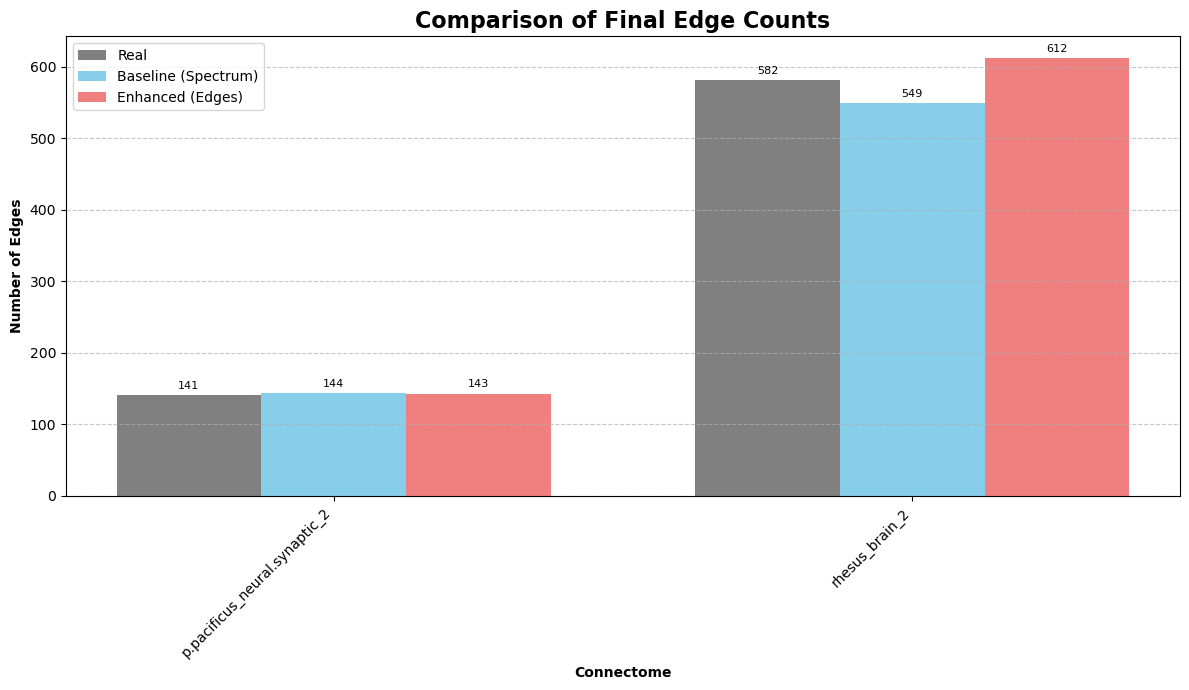

In [93]:
# --- Plot Overall Edge Count Comparison ---

connectome_names_list = list(all_results.keys())
real_edges = []
baseline_edges = []
enhanced_edges = []

for name in connectome_names_list:
    results = all_results[name]
    real_edges.append(results.get('Real', {}).get('n_edges', np.nan))

    baseline_res = results.get('Baseline_Spectrum')
    baseline_edges.append(baseline_res['graph'].number_of_edges() if baseline_res else np.nan)

    enhanced_res = results.get('Enhanced_Edges')
    enhanced_edges.append(enhanced_res['graph'].number_of_edges() if enhanced_res else np.nan)

# Create DataFrame for easier plotting
df_edges = pd.DataFrame({
    'Connectome': [name.replace('.graphml', '') for name in connectome_names_list],
    'Real': real_edges,
    'Baseline': baseline_edges,
    'Enhanced': enhanced_edges
})

# Plotting
fig_edges, ax_edges = plt.subplots(figsize=(12, 7))
bar_width = 0.25
index = np.arange(len(connectome_names_list))

bar1 = ax_edges.bar(index - bar_width, df_edges['Real'], bar_width, label='Real', color='gray')
bar2 = ax_edges.bar(index, df_edges['Baseline'], bar_width, label='Baseline (Spectrum)', color='skyblue')
bar3 = ax_edges.bar(index + bar_width, df_edges['Enhanced'], bar_width, label='Enhanced (Edges)', color='lightcoral')

ax_edges.set_xlabel('Connectome', fontweight='bold')
ax_edges.set_ylabel('Number of Edges', fontweight='bold')
ax_edges.set_title('Comparison of Final Edge Counts', fontsize=16, fontweight='bold')
ax_edges.set_xticks(index)
ax_edges.set_xticklabels(df_edges['Connectome'], rotation=45, ha="right")
ax_edges.legend()
ax_edges.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on top of bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
             ax_edges.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

plt.tight_layout()
edge_comp_save_path = os.path.join(plot_save_dir, 'overall_edge_comparison.png')
fig_edges.savefig(edge_comp_save_path, dpi=300)
print(f"\nOverall edge comparison plot saved to {edge_comp_save_path}")
plt.show()

In [94]:
123456789

123